In [1]:
# =========================================================
# Job Corps: DML(mediated) — Multi-GPU, efficient, timed
# =========================================================

# --- Limit BLAS/OpenMP threads BEFORE importing heavy libs ---
import os as os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

# --- Std libs ---
import sys, time, platform
from pathlib import Path

# --- Third-party ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from threadpoolctl import threadpool_limits
threadpool_limits(1)  # keep NumPy/BLAS at 1 thread

import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression

# NNPIV
from nnpiv.neuralnet import AGMM, AGMM2L2
from nnpiv.rkhs import ApproxRKHSIVCV
from nnpiv.semiparametrics import DML_mediated

# -----------------------
# Compute resources print
# -----------------------
def print_resources():
    dev_cnt = torch.cuda.device_count()
    devs = [torch.cuda.get_device_name(i) for i in range(dev_cnt)] if dev_cnt else []
    print("=== Compute resources ===")
    print(f"Python       : {sys.version.split()[0]}")
    print(f"NumPy        : {np.__version__}")
    print(f"PyTorch      : {torch.__version__}")
    print(f"CPU cores    : {os.cpu_count()}")
    print(f"CUDA devices : {dev_cnt} -> {devs}")
    print(f"Platform     : {platform.platform()}")
    print("=========================\n")

print_resources()

# Canonical device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

=== Compute resources ===
Python       : 3.10.18
NumPy        : 2.2.6
PyTorch      : 2.5.0
CPU cores    : 64
CUDA devices : 4 -> ['NVIDIA A100-SXM4-40GB MIG 3g.20gb', 'NVIDIA A100-SXM4-40GB MIG 3g.20gb', 'NVIDIA A100-SXM4-40GB MIG 3g.20gb', 'NVIDIA A100-SXM4-40GB MIG 3g.20gb']
Platform     : Linux-4.18.0-553.44.1.el8_10.x86_64-x86_64-with-glibc2.28



In [2]:

# -----------------------
# Data loading (float32)
# -----------------------
df = pd.read_csv("../data/JCdata.csv", delimiter=" ", header=0)

# mask once to avoid recomputation
mask = (df["e12missdum"] == 0).values

X_cols = ["female","age","race_white","race_black","race_hispanic",
          "educ_geddiploma","educ_hsdiploma","ntv_engl","marstat_divorced",
          "marstat_separated","marstat_livetogunm","marstat_married","haschldY0",
          "everwkd","mwearn","hohhd0","nonres","g10","g10missdum",
          "work_dad_didnotwork","g2","g5","g7","welfare_child","welfare_childmissdum",
          "h1_fair_poor","h2","h29","h5","h5missdum","h7","h7missdum","i1","i10"]

X = df.loc[mask, X_cols].to_numpy(dtype=np.float32)

# binary A from d>0
a_series = (df.loc[mask, "d"] > 0).astype(np.int32)
df.loc[mask, "a"] = a_series  # store once, reuse below

Z = df.loc[mask, ["e12","e37"]].to_numpy(dtype=np.float32)
W = df.loc[mask, ["e32","e8_recruitersoffice"]].to_numpy(dtype=np.float32)

Y = df.loc[mask, ["y"]].to_numpy(dtype=np.float32)
M = df.loc[mask, ["m"]].to_numpy(dtype=np.float32)
D = df.loc[mask, ["a"]].to_numpy(dtype=np.float32)


In [3]:

# -----------------------
# Model builders (NN)
# -----------------------
p = 0.10
n_hidden = 400

def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


# AGMM2L2 (simultaneous) for bridges in mediated DML
agmm2 = AGMM2L2(learnerh = _get_learner(36), learnerg = _get_learner(37),
                     adversary1 = _get_adversary(37), adversary2 = _get_adversary(36))
agmm2_q = AGMM2L2(learnerh = _get_learner(37), learnerg = _get_learner(36),
                     adversary1 = _get_adversary(36), adversary2 = _get_adversary(37))

# Outcome and treatment auxiliary models
agmm_y = AGMM(_get_learner(34),_get_adversary(2))
agmm_a = AGMM(_get_learner(36),_get_adversary(36))


# Common fitargs for NN
fit_nn_big = {
    "n_epochs": 500, "bs": 100,
    "learner_lr": 1e-4, "adversary_lr": 1e-4,
    "learner_l2": 1e-3, "adversary_l2": 1e-4,
    "device": DEVICE,  
}
fit_nn_med = {
    "n_epochs": 450, "bs": 100,
    "learner_lr": 1e-4, "adversary_lr": 1e-4,
    "learner_l2": 1e-3, "adversary_l2": 1e-4,
    "device": DEVICE,
}


In [4]:

# -----------------------
# Run DML — Neural Nets
# -----------------------

dml_agmm = DML_mediated(Y, D, M, W, Z, X,
                        estimand='Direct',
                        model1 = agmm2,
                        modelq1 = agmm2_q,
                        model_y = agmm_y,
                        model_a = agmm_a,
                        n_folds=5, n_rep=1,
                        CHIM = True,
                        prop_score=LogisticRegression(max_iter=3000),
                        nn_1 = True,
                        nn_q1 = True,
                        nn_y = True,
                        nn_a = True,
                        fitargs1 = fit_nn_big,
                        fitargsq1 = fit_nn_big,
                        fitargsy = fit_nn_med,
                        fitargsa = fit_nn_med,
                        opts = {'burnin': 350})

t0 = time.perf_counter()
theta_nn, var_nn, ci_nn = dml_agmm.dml()
t1 = time.perf_counter()
print(f"[NN] time = {t1 - t0:.2f}s")
theta_nn = float(np.atleast_1d(theta_nn)[0])
var_nn   = float(np.atleast_1d(var_nn)[0])
ci_nn    = np.array(ci_nn, dtype=float).reshape(-1)


Rep: 1


100%|██████████| 5/5 [51:34<00:00, 618.98s/it]   

[NN] time = 3094.93s


In [5]:

# -----------------------
# Run DML — RKHS
# -----------------------
rkhs_model = ApproxRKHSIVCV(
    kernel_approx="nystrom", n_components=100,
    kernel="rbf", gamma=0.1, delta_scale="auto",
    delta_exp=0.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5
)

dml_rkhs = DML_mediated(
    Y, D, M, W, Z, X,
    estimand="Direct",
    model1=[rkhs_model, rkhs_model],
    modelq1=[rkhs_model, rkhs_model],
    nn_1=[False, False],
    nn_q1=[False, False],
    fitargs1=[None, None],
    fitargsq1=[None, None],
    n_folds=5, n_rep=3, CHIM=True,
    prop_score=LogisticRegression(max_iter=2000),
)

t0 = time.perf_counter()
theta_rk, var_rk, ci_rk = dml_rkhs.dml()
t1 = time.perf_counter()
print(f"[RKHS] time = {t1 - t0:.2f}s")
theta_rk = float(np.atleast_1d(theta_rk)[0])
var_rk   = float(np.atleast_1d(var_rk)[0])
ci_rk    = np.array(ci_rk, dtype=float).reshape(-1)


Rep: 1


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Rep: 2


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Rep: 3


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

[RKHS] time = 16.50s


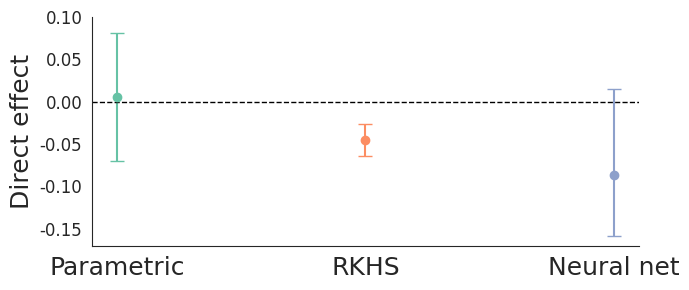

In [6]:

# -----------------------
# Assemble plot data
# -----------------------

# 'Parametric' estimator is retrieved from Table 2 of 
# Oliver Dukes, Ilya Shpitser, Eric J Tchetgen Tchetgen, Proximal mediation analysis, Biometrika, Volume 110, Issue 4, December 2023, Pages 973–987, https://doi.org/10.1093/biomet/asad015 
estimators       = ["Parametric", "RKHS", "Neural net"]
point_estimates  = [0.0057, theta_rk, theta_nn]
lower_bounds     = [-0.0699, float(ci_rk[0]), float(ci_nn[0])]
upper_bounds     = [ 0.0813, float(ci_rk[1]), float(ci_nn[1])]

errors = [
    np.array([point_estimates[i] - lower_bounds[i],
              upper_bounds[i] - point_estimates[i]])
    for i in range(len(estimators))
]

# -----------------------
# Plot
# -----------------------
sns.set_style("white")
sns.set_palette("Set2")
plt.figure(figsize=(7, 3))

for i, est in enumerate(estimators):
    plt.errorbar(
        est, point_estimates[i],
        yerr=errors[i].reshape(2, 1),
        fmt="o", capsize=5
    )

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.ylabel("Direct effect", fontsize=18)
plt.xlabel("", fontsize=20)
plt.xticks(rotation=0, fontsize=18)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
plt.yticks([-0.15, -0.1, -0.05, 0.0, 0.05, 0.1], fontsize=12)
plt.tight_layout()
sns.despine()
plt.savefig("../output/jobcorps1.png", dpi=800, bbox_inches="tight")
plt.show()
